# Задание 03

### 1. Связь AUC-ROC  и доли верных ответов (2 балла)
Пусть дана некоторая выборка $X$ и классификатор $b(x)$, возвращающий в качестве оценки принадлежности объекта $x$ к положительному классу 0 или 1 (а не вероятности). 

1) Постройте ROC-кривую для классификатора $b(x)$ на выборке $X$.

2) Покажите, что AUC-ROC классификатора $b(x)$ может быть выражена через долю правильных ответов и полноту классификатора $a(x;t)$, получающегося при выборе некоторого порога $t \in (0;1)$ ($a(x)=[b(x)>t]$). Помимо указанных величин в формулу могут входить $N,N_+,N_-$, число объектов, число положительных и отрицательных объектов в выборке $X$ соответсвенно. 


### 2. ROC, PR кривые  (2 балла)
Алгоритм  бинарной классификации выдает оценки вероятности принадлежности к положительному классу  $b_i=\hat{\mathcal{ P}}(y_i=+|x_i)$. Всего есть $N=10 000$ наблюдений. Если ранжировать их по возрастанию $b_i$, то окажется, что наблюдения с $y_i=1$ и наблюдения с $y_i=0$ образуют чередующиеся блоки различного размера:
$$
\underbrace{-------}_{3N/8}\underbrace{+++++++}_{3N/8}\underbrace{-------}_{N/8}\underbrace{+++++++}_{N/8}
$$
Постройте $ROC$ и $PR$ кривые, определите площади под кривыми. 

### 1.1

Согласно построению ROC кривой, ранжируем объекты по предсказанной принадлежности классу - верхняя часть с предсказанной принадлежностью к положительному классу,нижняя - с предсказанной принадлежность к отрицательному классу. Таким образом график ROC , будет выглядеть так: 2 линии (0,0) -> ($FPR$, $TPR$) -> (1,1), где $FPR$ и $TPR$ - false positive rate и true positive rate классификатора b(x). Один из возможных графиков представлен внизу.

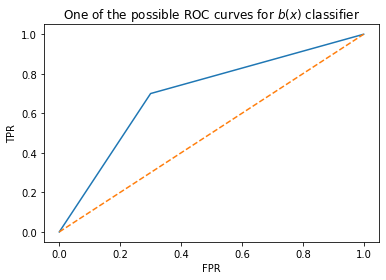

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
fpr, tpr = [0, 0.3, 1], [0, 0.7, 1]

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title("One of the possible ROC curves for $b(x)$ classifier")
plt.xlabel("FPR")
plt.ylabel("TPR");

### 1.2

Исходя из предыдущего задания $ROC-AUC = \frac{1}{2}(FPR * TPR + (1 - FPR)*(1 - TPR)) + TPR*(1 - FPR) = \frac{1}{2}(1 + TPR - FPR)$
Выразим $FPR$ и $TPR$ через $ACC$ и $Recall$:  
$$ACC = \frac{TP + TN}{N} \Rightarrow N*ACC = TP + TN$$
$$TPR = \frac{TP}{N_+} \Rightarrow TP = TPR * N_+ $$
$$(1-FPR) = \frac{TN}{N_-} \Rightarrow TN = (1 - FPR)* N_- $$
$$ N * ACC = TPR * N_+ + (1 - FPR) * N_- $$
$$ TPR = Recall $$
$$ (1 - FPR) = \frac{N * ACC - Recall * N_+}{N_-} $$
Подставим в формулу для $ROC-AUC$:
$$ ROC-AUC = \frac{1}{2}(1 + TPR - FPR) = \frac{1}{2}(\frac{N * ACC - Recall * N_+ + Recall * N_-}{N_-}) = \frac{1}{2}(\frac{N * ACC + Recall * (N_- - N_+)}{N_-})$$

### 2
Предположим, что нет объектов с одинаковыми вероятностями на стыках блоков. Тогда кривая ROC будет содержать только вертикальные и горизонтальные участки, проходящие через точки (0,0) -> (0, 1/4) -> (1/4, 1/4) -> (1/4, 1) -> (1,1). PR кривая будет ломанной, проходящей через точки (1,1) -> (1/4,1) -> (1/4,1/2) -> (1,8/10) -> (1,0)

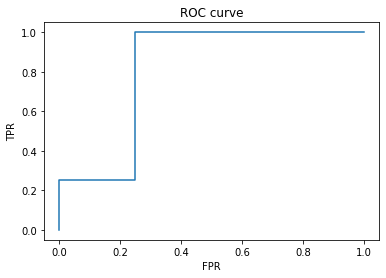

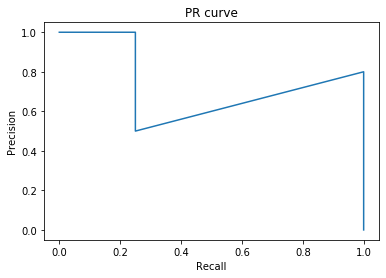

ROC-AUC 0.8125
ROC-PR 0.7375


In [45]:
from sklearn import metrics

FPR = [0, 0, 1/4, 1/4, 1]
TPR = [0, 1/4, 1/4, 1, 1]

Precision = [1, 1, 1/2, 8/10, 0]
Recall = TPR

plt.plot(FPR, TPR)
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

plt.plot(Recall, Precision)
plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("ROC-AUC {}".format(metrics.auc(FPR, TPR)))
print("PR-AUC {}".format(metrics.auc(Recall, Precision)))

### 3. Логистическая регрессия на данных (6 баллов )

In [46]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

### [Данные](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
Будем анализировать данные, связанные с прямыми маркетинговыми кампаниями (телефонными звонками) португальского банковского учреждения. Цель классификации - предсказать, будет ли клиент подписывать (1/0) срочный депозит (переменная y).



   #### bank client data:
   * 1 - age (numeric)
   * 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
      "blue-collar","self-employed","retired","technician","services") 
   * 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   * 4 - education (categorical: "unknown","secondary","primary","tertiary")
   * 5 - default: has credit in default? (binary: "yes","no")
   * 6 - balance: average yearly balance, in euros (numeric) 
   * 7 - housing: has housing loan? (binary: "yes","no")
   * 8 - loan: has personal loan? (binary: "yes","no")
   related with the last contact of the current campaign:
   * 9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
   * 10 - day: last contact day of the month (numeric)
   * 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   * 12 - duration: last contact duration, in seconds (numeric)
   other attributes:
   * 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   * 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   * 15 - previous: number of contacts performed before this campaign and for this client (numeric)
   * 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  #### Output variable (target):
   * 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [47]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google'

In [48]:
data = pd.read_csv('bank.csv', sep=';',header=0)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [49]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB
None


#### 3.1. Какова доля положительных объектов в выборке?

In [50]:
percent = (data['y'] == 'yes').sum() / len(data['y']) 
print(percent)

0.11523999115239991


####  3. 2. Подготовка данных. 
1. Подготовьте матрицу объект-признак:
 * удалите (но не навсегда!) целевой признак ('y') 

 * удалите признак 'day' (можно навсегда) 

 * Все категориальные признаки преобразуйте в бинарные, используя [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 


2. Подготовьте целевой вектор: 
    
 * преобразуйте признак 'y' в вектор, состоящий из нулей (y='no') и единиц (y='yes').
 

In [51]:
if 'day' in data.columns:
    data.drop(columns="day", inplace=True)

if 'y' in data.columns:
    y = np.where(data.iloc[:, -1].values == 'yes', 1, 0)
    data.drop(columns="y", inplace=True)
    
X = pd.get_dummies(data)


#### 3. 3. Логистическая регрессия.

* Разделите выборку в соотношении 70:30;

* Обучите логистическую регрессию с параметрами по умолчанию. 


In [52]:
np.random.seed(17)
lr = LogisticRegression(solver='liblinear')

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

#### 3.4. Чему равны следующие метрики качества:

   * Доля верных предсказаний,
   * Точность,
   * Полнота,
   * F1-мера? 

In [53]:
print ('Accuracy =', metrics.accuracy_score(y_test, y_pred))
print ('Precision =', metrics.precision_score(y_test, y_pred))
print ('Recall =', metrics.recall_score(y_test, y_pred))
print ('F1 score =', metrics.f1_score(y_test, y_pred))

Accuracy = 0.9093588798820929
Precision = 0.6176470588235294
Recall = 0.302158273381295
F1 score = 0.4057971014492754


#### 3.5. Постройте ROC кривую и найдите площадь под кривой. 

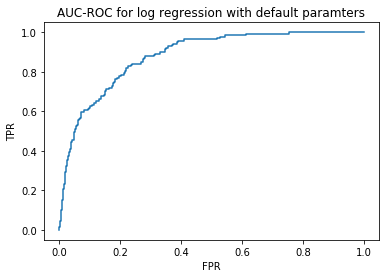

AUC-ROC 0.8815548546384567


In [54]:
probs=lr.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC-ROC for log regression with default paramters")
plt.show()

print("AUC-ROC {}".format(metrics.auc(fpr, tpr)))

#### 3.6. Порог $t$ в модели логистической регрессии по умолчанию $t=0.5$. 

$a(x) = \begin{cases}
        +1, \, b(x) \ge t,\\
        -1, \, b(x) < t.
        \end{cases}$ 
        
Измените порог на $t=0.2$. Как изменятся метрики качества для такого классификатора? 


In [55]:
y_pred_threshold = np.where(probs[:,1] >= 0.2, 1, 0 )

print ('Accuracy =', metrics.accuracy_score(y_test, y_pred_threshold))
print ('Precision =', metrics.precision_score(y_test, y_pred_threshold))
print ('Recall =', metrics.recall_score(y_test, y_pred_threshold))
print ('F1 score =', metrics.f1_score(y_test, y_pred_threshold))


Accuracy = 0.8725128960943257
Precision = 0.4182692307692308
Recall = 0.6258992805755396
F1 score = 0.5014409221902018


Доля верных ответов незначительно уменьшилась. Точность уменьшилась, так как увеличилось число ложно положительных объектов, полнота увеличилась, поскольку уменьшилось число ложно отрицательных объектов. F1 метрика увеличилась.

#### 3.7. Постройте логистическую регрессию, штрафующую несбалансированные классы по-разному (пропорционально доли класса). Как изменились метрики качества классификатора? 

In [56]:
lr_balanced = LogisticRegression(class_weight = "balanced", solver='liblinear')
lr_balanced.fit(X_train, y_train)
y_pred_balanced = lr_balanced.predict(X_test)

print ('Accuracy =', metrics.accuracy_score(y_test, y_pred_balanced))
print ('Precision =', metrics.precision_score(y_test, y_pred_balanced))
print ('Recall =', metrics.recall_score(y_test, y_pred_balanced))
print ('F1 score =', metrics.f1_score(y_test, y_pred_balanced))

Accuracy = 0.8084008843036109
Precision = 0.3149847094801223
Recall = 0.7410071942446043
F1 score = 0.44206008583690987


(По сравнению с первой моделью) Упали доля верных ответов, точность. F1 и полнота выросли, причем,
последняя значительно.

#### 3.8. Построите логистическую регрессию с L1-регуляризацией. С помощью GridSearchCV определите наилучший гиперпараметр С. 
Воспользуйтесь StratifiedKFold для кросс-валидации, при таком разбиении сохраняется соотношение классов в обучающей и тестовой выборках. 

In [57]:
from sklearn.model_selection import GridSearchCV

alphas=np.logspace(-2,3,50)
param_grid = {'C': alphas}

grid = GridSearchCV(LogisticRegression(penalty = "l1", solver="liblinear"), param_grid, cv = 3)
grid.fit(X, y)
print("Best params {}".format(grid.best_params_))

Best params {'C': 1.3894954943731375}


#### 3.9. Постройте зависимость средней ошибки классификатора (доля верных предсказаний) от значения параметра регуляризации. 

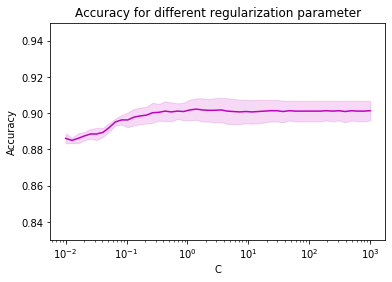

In [58]:
score_mean = grid.cv_results_['mean_test_score']
score_std=grid.cv_results_['std_test_score']
plt.fill_between(alphas, score_mean - score_std, score_mean + score_std, 
                 alpha = 0.15, color = 'm')
plt.semilogx(alphas, score_mean, color = 'm')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy for different regularization parameter")
plt.ylim(ymax = 0.95, ymin = 0.83)
plt.show()